2025-03-27 13:25:11.075720: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-27 13:25:11.129784: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-27 13:25:11.129933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-27 13:25:11.131426: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-27 13:25:11.141808: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-27 13:25:11.144712: I tensorflow/core/platform/cpu_feature_guard.cc:1

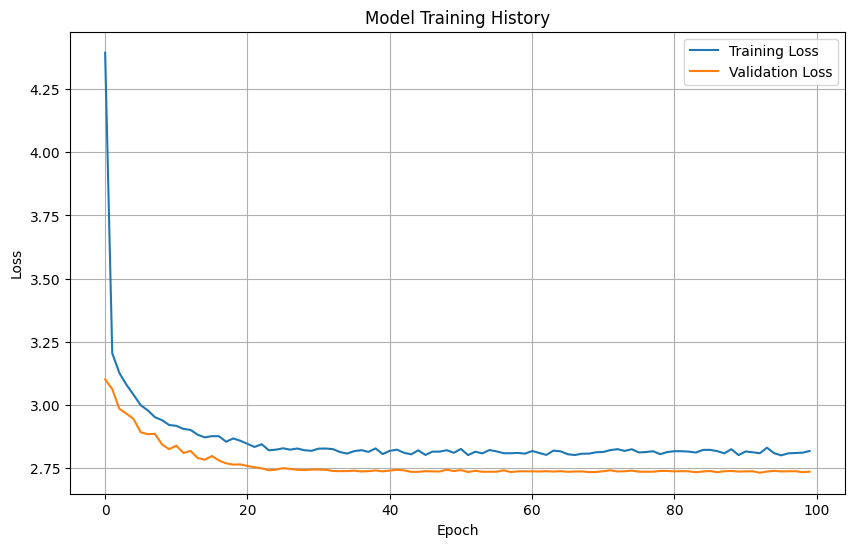

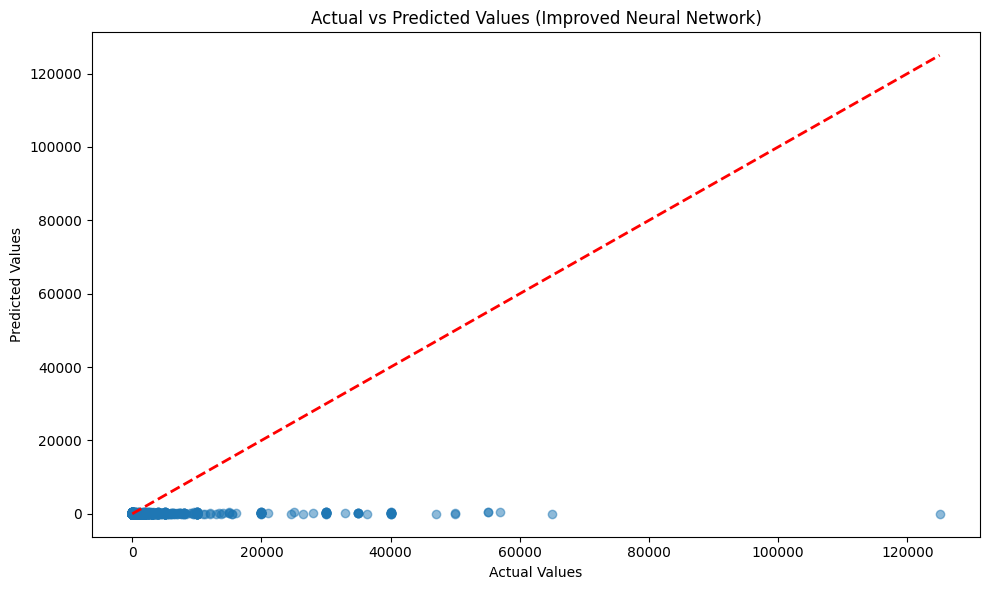

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Read data
df = pd.read_csv('bird_final.csv')

# Store original numeric columns
original_df = df.copy()

# Temporal Features
df['MONTH_SIN'] = np.sin(2 * np.pi * df['month']/12)
df['MONTH_COS'] = np.cos(2 * np.pi * df['month']/12)
quarter_dummies = pd.get_dummies(pd.cut(df['month'], bins=[0,3,6,9,12], labels=['Q1','Q2','Q3','Q4']), prefix='QUARTER')
df = pd.concat([df, quarter_dummies], axis=1)

# Geographic Features
lat_dummies = pd.get_dummies(pd.qcut(df['LATITUDE'], q=5, labels=['Very South', 'South', 'Mid', 'North', 'Very North']), prefix='LAT')
lon_dummies = pd.get_dummies(pd.qcut(df['LONGITUDE'], q=5, labels=['Far West', 'West', 'Mid', 'East', 'Far East']), prefix='LON')
df = pd.concat([df, lat_dummies, lon_dummies], axis=1)

#Environmental Interactions
df['TEMP_RAIN_INTERACTION'] = df['AVERAGE MONTH TEMPERATURE'] * df['AVERAGE MONTH RAINFALL']
df['NDVI_TEMP_INTERACTION'] = df['NDVI'] * df['AVERAGE MONTH TEMPERATURE']
df['NDVI_RAIN_INTERACTION'] = df['NDVI'] * df['AVERAGE MONTH RAINFALL']

#Population and Density Features
df['POPULATION_LOG'] = np.log1p(df['Population'])
df['POPULATION_DENSITY_LOG'] = np.log1p(df['Population Density'])
pop_density_dummies = pd.get_dummies(pd.qcut(df['Population Density'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']), prefix='POP_DENSITY')
df = pd.concat([df, pop_density_dummies], axis=1)

# Distance-based Features
df['DISTANCE_FROM_EQUATOR'] = abs(df['LATITUDE'])
df['COASTAL_PROXIMITY'] = abs(df['LONGITUDE']) % 90

#Advanced Environmental Features
df['NDVI_SQUARED'] = df['NDVI'] ** 2
df['TEMP_SQUARED'] = df['AVERAGE MONTH TEMPERATURE'] ** 2
df['RAINFALL_SQUARED'] = df['AVERAGE MONTH RAINFALL'] ** 2

# Combined Geographic Features
df['AREA_FACTOR'] = df['LATITUDE'].abs() * df['LONGITUDE'].abs()
df['GEO_TEMP_INTERACTION'] = df['AREA_FACTOR'] * df['AVERAGE MONTH TEMPERATURE']

# Select original numeric columns and engineered features
numeric_features = ['LATITUDE', 'LONGITUDE', 'AVERAGE MONTH TEMPERATURE', 
                   'AVERAGE MONTH RAINFALL', 'tree_loss_ha', 'percentage_loss',
                   'Population', 'NDVI', 'Population Density', 'month', 'WT_COUNT_10KM_RADIUS',
                   'MONTH_SIN', 'MONTH_COS', 'TEMP_RAIN_INTERACTION', 'NDVI_TEMP_INTERACTION',
                   'NDVI_RAIN_INTERACTION', 'POPULATION_LOG', 'POPULATION_DENSITY_LOG',
                   'DISTANCE_FROM_EQUATOR', 'COASTAL_PROXIMITY', 'NDVI_SQUARED',
                   'TEMP_SQUARED', 'RAINFALL_SQUARED', 'AREA_FACTOR', 'GEO_TEMP_INTERACTION']

#Get columns
binary_columns = [col for col in df.columns if col.startswith(('QUARTER_', 'LAT_', 'LON_', 'POP_DENSITY_'))]

# Combine features
all_features = numeric_features + binary_columns

# Prepare X and y
X = df[all_features]
y = df['OBSERVATION COUNT']

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

#Scale target (using log transformation for better handling of large values)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Build improved neural network
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(16, activation='relu'),
    BatchNormalization(),
    
    Dense(1)
])

# Compile model with learning rate schedule
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='mse')

# Add callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Train model
history = model.fit(
    X_train_scaled, y_train_log,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

#Make predictions and convert back from log scale
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"R-squared Score: {r2:.4f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

#Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Neural Network)')
plt.tight_layout()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7bb86bc8-88ca-4d86-bf40-feedf16fde30' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>